Note: This has reference to implementation by Sentdex

In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from pprint import pprint
style.use('ggplot')

In [4]:
class Support_Vector_Machine():
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1: 'r', -1: 'b'}
        
    # Train
    def fit(self, data):
        # Note: Enable comments ending with trailing # to store values for w_vector plotting considering below warning,
        # Caution: Do not enable/or-try plotting when using step multiplier(check out step_sizes) of greater than 0.01[too many values to store, might freeze computer]
        
        self.data = data
        
        # { ||w||: [w,b] }
        opt_dict = {} # To store optimal weighhts
        
        # Initialize transforms
        transforms = [[1, 1], 
                      [-1, 1], 
                      [-1, -1], 
                      [1, -1]]
        
        all_data =[]
        # Store each feature in list
        for label in self.data:
            for featureset in self.data[label]:
                for feature in featureset:
                    all_data.append(feature)
        
        # Extract max feature value and min feature value
        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        all_data = None # discard all_data to save memory
        
        # SV candidate definition
        # xi.w+b = 1 .. when y = 1 ... [1]
        # xi.w+b = -1 .. when y = 0 ... [2]
        # Multiplying both sides by y
        # y(xi.w+b) = y(1) ... [1]
        # y(xi.w+b) = y(-1) ... [2]
        # Hence we get
        # y(xi.w+b) = 1
        
        # Optimization step strides
        step_sizes = [self.max_feature_value * 0.1,
                     self.max_feature_value * 0.01,
                     # costly computation
                     self.max_feature_value * 0.001]
        
        # Bias range multiplier
        b_range_multiple = 2
        
        # bias step stride
        b_multiple = 5
        
        # Initial optimum value
        latest_optimum = self.max_feature_value*10
        
        # Container to plot non-optimized w, b traversal
        w_min = [] #
        step_idxs = [] #
        # Try each step stride
        for si, step in enumerate(step_sizes):
            #w_min_step = [] #
            #b_min_step = [] #
            # initialize weight/paramenter vector
            w = np.array([latest_optimum, latest_optimum])
            # Optimized flag, activated when w[0] crosses 0 (origin)
            optimized = False
            # Keep trying and minimizing w, to find set of w's that classifies
            # each example correctly with a confidence specified by equation
            # 'y*(np.dot(w_t,xi)+b) >= 1', which is of >= 1 (Large margin)
            while not optimized:
                # Iteratively shift bias from negative to positive
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple,
                                   step * b_multiple):
                    # Try w in each quadrant
                    for transformation in transforms:
                        w_t = w * transformation
                        
                        # Offload the w_t and b to step container for plotting
                        #w_min_step.append(w_t) #
                        #b_min_step.append(b) #
                        
                        w_min.append(w_t)
                        step_idxs.append(si)
                        
                        # Classification flag, 
                        # Initially set to True,
                        # but if wrong classification is made... it is changed to False
                        found_option = True
                        
                        # Try w_t and b w.r.t to all examples,
                        # validate if they both serve SV criteria (correctly classify with large margin confidence),
                        # to be accepted as a candidate support vector.
                        for yi in self.data:
                            for xi in self.data[yi]:
                                if not yi*(np.dot(w_t, xi)+b) >= 1:
                                    # Wrong classification detected
                                    # Hence, doesn't serve the criteria(condition)
                                    found_option = False
                        
                        # If current w_t and b made all classification correctly it is a possible SV
                        if found_option:
                            # Store magnitude of w_t as key,
                            # and w_t and b as value
                            opt_dict[np.linalg.norm(w_t)] = [w_t, b]
                        
                if w[0] < 0: # if crosses 0 (origin), marks the exit of current step
                    optimized = True
                    print('Optimized a step.')
                else: # minimize w
                    w = w - step
                    
            # Offload step container to w_b_min        
            #w_min.append(np.array(w_min_step)) #
            #b_min.append(np.array(b_min_step)) #
            
            # Sort opt_dict(which stores possbile support vectors), according to magnitude
            norms = sorted([n for n in opt_dict])
            #||w|| : [w,b]
            # Choose the w vector with lowest magnitude achieved in our current step
            # This w vector is utilized in the next iteration as starting point(latest_optimum)
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0] # vector
            self.b = opt_choice[1] # bias
            # latest_optimum fournd in current step is utilized as starting point with
            # a slight step back (which is sstep*2)
            latest_optimum = opt_choice[0][0] + step*2
            
        self.visualize()
            
        return np.array(w_min), np.array(step_idxs) #
    
    
    # Predict
    def predict(self, features):
        # sign( x.w+b ) .... [+ is positive class and - is negative class]
        classification = np.sign(np.dot(np.array(features), self.w) + self.b)
        if classification != 0 and self.visualization: # plot point with color based on classification
            self.ax.scatter(features[0], features[1], s=200, marker="*", c=self.colors[classification])
        return classification
    
    
    # Visualize
    def visualize(self):
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1, 1, 1)
        # Plot training points
        [[self.ax.scatter(x[0],x[1],s=50,color=self.colors[i]) for x in data_dict[i]] for i in data_dict]
        
        # hyperplane = x.w+b
        # v = x.w+b ... (v = value we are expecting)
        # psv = 1 (Positive support vector)
        # nsv = -1 (Negative support vector)
        # dec = 0 (Decision boundary)
        def hyperplane(x, w, b, v):
            return (-w[0]*x-b+v) / w[1]
        
        datarange = (self.min_feature_value*0.9, self.max_feature_value*1.1)
        hyp_x_min = datarange[0]
        hyp_x_max = datarange[1]
        
        # (w.x+b) = 1
        # positive support vector hyperplane
        psv1 = hyperplane(hyp_x_min, self.w, self.b, 1)
        psv2 = hyperplane(hyp_x_max, self.w, self.b, 1)
        self.ax.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'k')
        
        # (w.x+b) = -1
        # negative support vector hyperplane
        nsv1 = hyperplane(hyp_x_min, self.w, self.b, -1)
        nsv2 = hyperplane(hyp_x_max, self.w, self.b, -1)
        self.ax.plot([hyp_x_min,hyp_x_max],[nsv1,nsv2], 'k')

        # (w.x+b) = 0
        # positive support vector hyperplane
        db1 = hyperplane(hyp_x_min, self.w, self.b, 0)
        db2 = hyperplane(hyp_x_max, self.w, self.b, 0)
        self.ax.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--')
        

In [5]:
data_dict = {
    -1: np.array([[1, 7], [2, 8], [3, 8]]),
     1: np.array([[5, 1], [6, -1], [7, 3]])
}

In [6]:
svc = Support_Vector_Machine()

Optimized a step.
Optimized a step.
Optimized a step.


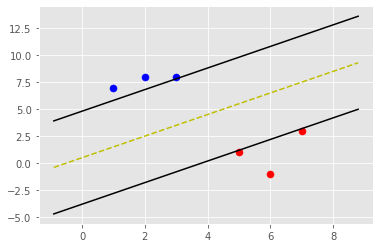

In [7]:
# w_hist, b_hist = svc.fit(data=data_dict) # 
#svc.fit(data=data_dict)
w_hist, step_idxs = svc.fit(data=data_dict)

In [8]:
predict_us = [[0,10],
              [1,3],
              [3,4],
              [3,5],
              [5,5],
              [5,6],
              [6,-5],
              [5,8]]

In [9]:
predictions = []
for p in predict_us:
    predictions.append(svc.predict(p))

In [10]:
predictions

[-1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0]

#### Visualizing w vector postions

In [10]:
from matplotlib import animation

In [11]:
#w_d = w_hist[0]
w_d = w_hist
w_d

array([[ 80. ,  80. ],
       [-80. ,  80. ],
       [-80. , -80. ],
       ...,
       [  0.8,  -0.8],
       [  0.8,   0.8],
       [ -0.8,   0.8]])

In [12]:
# #b_d = b_hist[0] 
# b_d = b_hist 
# b_hist

In [13]:
# def visualize_w(w_vec, step_idxs, file_name_str='test.mp4', fps=120):
#     fig = plt.figure(figsize=[10, 10])
#     xlim_max = w_vec[0][0] + 30 # + np.max(b_d)
#     xlim_min = -(w_vec[0][0] + 30) #+ np.max(b_d))
#     ax = plt.axes(xlim=(xlim_min, xlim_max), ylim=(xlim_min, xlim_max))
#     ax.axhline(y=0, color='#9F9F9F')
#     ax.axvline(x=0, color='#9F9F9F')
#     w_vector, = ax.plot([], [], 'o')
#     colors = np.array(['#00bfff', '#6a00ff', '#ff0080'])
#     def init():
#         w_vector.set_data([], [])
#         return w_vector,

#     def animate(i):
#         # Control limits
#         if i >= w_vec.shape[0]:
            
#         else:
#         window_size = 40
#         if i > window_size:
#             # Fetch last 50 raw values 
#             x_max = np.max(np.abs(w_vec[i-window_size:i, 0]))
#             x_min = -(x_max)
#             ax.set_xlim(x_min, x_max)
            
#         s_i = step_idxs[:i]
        
#         color = colors[step_idxs[i]] 
#         x_raw = w_vec[:i, 0]
#         y_raw = w_vec[:i, 1]
#         w_vector.set_data(x_raw, y_raw)
#         w_vector.set_c(color)
#         return w_vector,

#     anim = animation.FuncAnimation(fig, animate, init_func=init, frames=w_vec.shape[0]+6000, interval=2, blit=False)

#     FFwriter = animation.FFMpegWriter(fps=fps, extra_args=['-vcodec', 'libx264']) # Very slow [writing] use d
#     anim.save(file_name_str, writer = FFwriter)

In [14]:
#visualize_w(w_d, step_idxs, file_name_str='ts3.mp4')

In [15]:
#visualize_w(w_d, step_idxs, file_name_str='ts4.mp4', fps=1200)

In [16]:
def visualize_w_scatter(w_vec, step_idxs, file_name_str='test.mp4', fps=120):
    fig = plt.figure(figsize=[10, 10])
    limit_buffer = 30
    xlim_max = w_vec[0][0] + limit_buffer # + np.max(b_d)
    xlim_min = -(w_vec[0][0] + limit_buffer) #+ np.max(b_d))
    ax = plt.axes(xlim=(xlim_min, xlim_max), ylim=(xlim_min, xlim_max))
    ax.axhline(y=0, color='#9F9F9F')
    ax.axvline(x=0, color='#9F9F9F')
    w_vector = ax.scatter([], [])
    colors = np.array(['#00bfff', '#6a00ff', '#ff0080'])
    roll_back_frames = fps * 3
    def init():
        w_vector.set_offsets([], [])
        return w_vector

    def animate(i):
        if i >= w_vec.shape[0]: # Roll back animation
            #Set axis limit
            rollback_frame_i = (i+1) - w_vec.shape[0]
            rollback_progress_percent = rollback_frame_i / np.float(roll_back_frames)
            x_max = xlim_max * rollback_progress_percent
            x_min = xlim_min * rollback_progress_percent
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(x_min, x_max)
            # Fetch entire data
            color_map= colors[step_idxs]
            x_raw = w_vec[:, 0]
            y_raw = w_vec[:, 1]
            w_vector.set_offsets(np.c_[x_raw, y_raw])
            w_vector.set_facecolors(color_map)
        else: # Roll in animation
            window_size = 40
            if i > window_size:
                # Fetch last 50 raw values 
                x_max = np.max(np.abs(w_vec[(i+1)-window_size:i+1, 0])) + limit_buffer
                x_min = -(x_max)
                ax.set_xlim(x_min, x_max)
                ax.set_ylim(x_min, x_max)
        
            color_map= colors[step_idxs[:i+1]]
            x_raw = w_vec[:i+1, 0]
            y_raw = w_vec[:i+1, 1]
            w_vector.set_offsets(np.c_[x_raw, y_raw])
            w_vector.set_facecolors(color_map)
        return w_vector,

    anim = animation.FuncAnimation(fig, animate, frames=w_vec.shape[0]+roll_back_frames, interval=2, blit=False)

    FFwriter = animation.FFMpegWriter(fps=fps, extra_args=['-vcodec', 'libx264']) # this is very slow[because of saving process] please use any different writer
    anim.save(file_name_str, writer = FFwriter)

In [25]:
#visualize_w_scatter(w_d, step_idxs, file_name_str='w_onestep.mp4', fps=150)

In [17]:
#visualize_w_scatter(w_d, step_idxs, file_name_str='w_allsteps.mp4', fps=1600) # Scary slow

One step w minimization

<img src="svm_quadratic_programming_w_minimization_one_step.gif" width="320" height="240">

Multi step w minimization

<img src="svm_quadratic_programming_w_minimization_multi_step.gif" width="320" height="240">